# Reproducing error detection results on prospective physical cat qubits

This notebook reproduces some of the results in [High-performance repetition cat code using fast noisy operations](https://arxiv.org/abs/2212.11927) [Le Régent et al., 2022] with a multi-qubit cat emulator.


The emulator is configured to have the same properties as the qubits used in the paper above. This study does not represent the current performance of Alice & Bob's cat qubits.

## Helper code for demo (skip)

In [1]:
from qiskit import QuantumCircuit, execute, transpile
from typing import Optional
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
from tqdm.notebook import tqdm
import warnings

# set default plot parameters
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',

    'font.family': 'serif',
    'font.size': 16,

    'figure.dpi': 72.0,

    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 5.0,
    'xtick.minor.size': 2.5,
    'ytick.major.size': 5.0,
    'ytick.minor.size': 2.5,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,

    'axes.grid': True,
    'axes.titlesize': 'larger',
    'axes.labelsize': 'larger',
    'legend.fontsize': 'larger',
    'grid.color': 'gray',
    'grid.linestyle': '--',
    'grid.alpha': 0.3,

    'lines.linewidth': 1.0,
    
    'figure.figsize': (16, 8)
})

In [2]:
def _measurement_cycle(distance: int) -> QuantumCircuit:
    cycle = QuantumCircuit(2 * distance - 1, distance - 1, name='cycle')
    for i in range(distance - 1):
        ancilla_idx = 2 * i + 1
        cycle.initialize('+', ancilla_idx)
    for i in range(distance - 1):
        ancilla_idx = 2 * i + 1
        cycle.cx(ancilla_idx, ancilla_idx + 1)
    for i in range(distance - 1):
        ancilla_idx = 2 * i + 1
        cycle.cx(ancilla_idx, ancilla_idx - 1)
    for i in range(distance - 1):
        ancilla_idx = 2 * i + 1
        cycle.measure_x(ancilla_idx, i)
    return cycle

def error_correction_cycle(distance: int, repetitions: int, initial_state: Optional[str] = None) -> QuantumCircuit:
    if initial_state is None:
        initial_state = distance * '+'
    circuit = QuantumCircuit(2 * distance - 1, distance + repetitions * (distance - 1))
    circuit.initialize(initial_state, range(0, distance * 2, 2))
    circuit.barrier()
    for cycle_idx in range(repetitions):
        first_bit = distance + cycle_idx * (distance - 1)
        circuit.append(_measurement_cycle(distance).to_instruction(), range(2 * distance - 1), range(first_bit, first_bit + distance - 1))
        circuit.barrier()
    for i in range(distance):
        circuit.measure_x(2 * i, i)
    return circuit

In [3]:
from pymatching import Matching


def build_check_matrix(distance: int) -> np.ndarray:
    return (np.identity(distance) + np.diag([1] * (distance - 1), 1))[:-1]


def build_detection_events(syndrome: np.ndarray) -> np.ndarray:
        detection_events = np.copy(syndrome)
        detection_events[:, 1:] = (
            detection_events[:, 1:] - detection_events[:, 0:-1]
        ) % 2
        return detection_events

class Decoder:
    def __init__(self, distance: int, repetitions: int):
        self._check_matrix = build_check_matrix(distance)
        self._matching = Matching(
            self._check_matrix, repetitions=repetitions + 1,
            weights=None,
            timelike_weights=None,
        )

    def decode(self, syndrome: np.ndarray) -> np.ndarray:
        detection_events = build_detection_events(syndrome)
        return self._matching.decode(detection_events)


def extract_results(distance: int, counts: dict[str, int]) -> list[dict]:
    H = build_check_matrix(distance)
    out = []
    for k, v in counts.items():
        d = {}
        d['output'] = np.array([int(c) for c in reversed(k[-distance:])])
        d['raw_syndrome'] = np.array([int(c) for c in reversed(k[:-distance])])
        rounds = d['raw_syndrome'].shape[0] // (distance - 1)
        syndrome = d['raw_syndrome'].reshape((rounds, distance - 1)).T
        d['syndrome'] = np.zeros((syndrome.shape[0], syndrome.shape[1] + 1))
        d['syndrome'][:, :-1] = syndrome
        d['syndrome'][:, -1] = d['output'] @ H.T
        d['count'] = v
        out.append(d)
    return out


def compare_results(output: np.ndarray, correction: np.ndarray) -> bool:
    return np.all(output == correction)


def decode_results(decoder: Decoder, results: list[dict]) -> float:
    n_logical_errors = 0
    shots = 0
    for d in results:
        correction = decoder.decode(d['syndrome'])
        if not compare_results(d['output'], correction):
            n_logical_errors += d['count']
        shots += d['count']
    return n_logical_errors / shots

## Instantiating the emulator

In [4]:
from qiskit_alice_bob_provider.local.provider import AliceBobLocalProvider
from qiskit_alice_bob_provider.local.backend import ProcessorSimulator
from qiskit_alice_bob_provider.processor.physical_cat import PhysicalCatProcessor
from qiskit_aer import AerSimulator

provider = AliceBobLocalProvider()

In [5]:
provider.backends()

[<ProcessorSimulator(name=EMU:6Q:PHYSICAL_CATS)>,
 <ProcessorSimulator(name=EMU:40Q:PHYSICAL_CATS)>,
 <ProcessorSimulator(name=EMU:40Q:LOGICAL_TARGET)>,
 <ProcessorSimulator(name=EMU:40Q:LOGICAL_EARLY)>,
 <ProcessorSimulator(name=EMU:1Q:LESCANNE_2020)>]

In [6]:
backend = provider.get_backend('EMU:40Q:PHYSICAL_CATS')

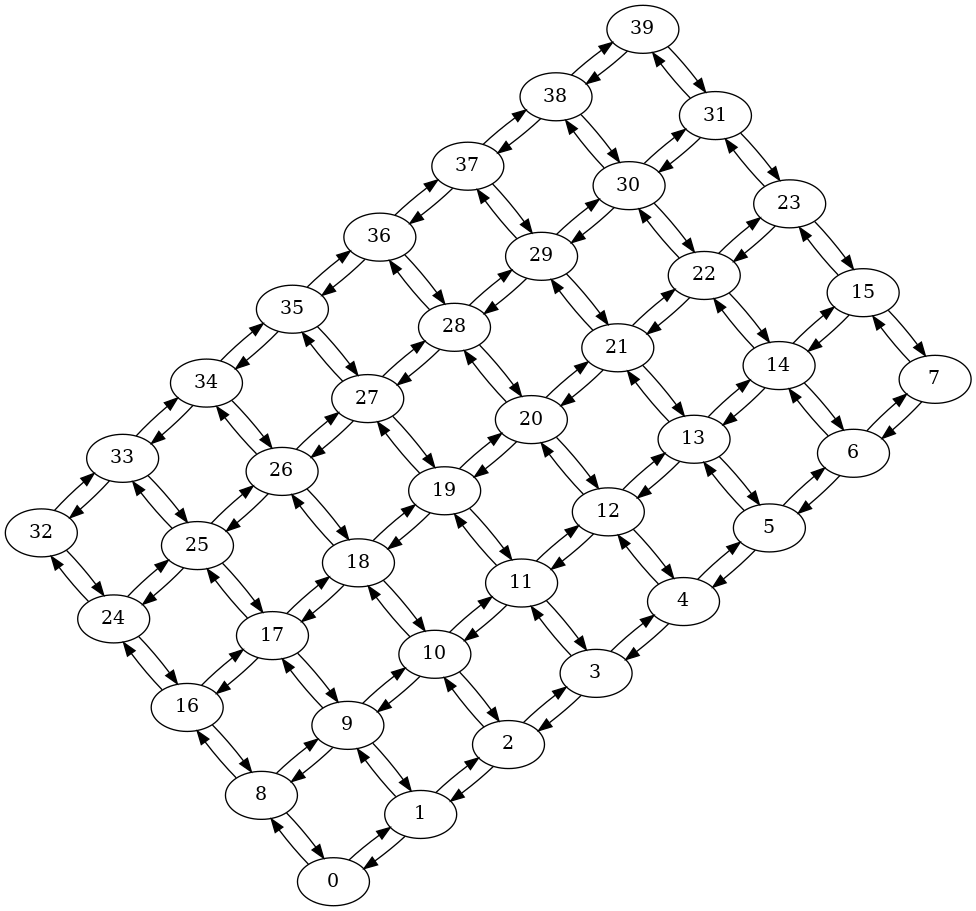

In [7]:
backend.coupling_map.draw()

## Detecting phase flip errors with a linear repetition code

Here's a circuit containing a single cycle distance-3 linear repetition code, with a single round of syndrome measurement:

/home/jdumazer/ab/emulation-examples/venv/lib/python3.9/site-packages/qiskit/utils/classtools.py:112: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  retval = method(*args, **kwargs)


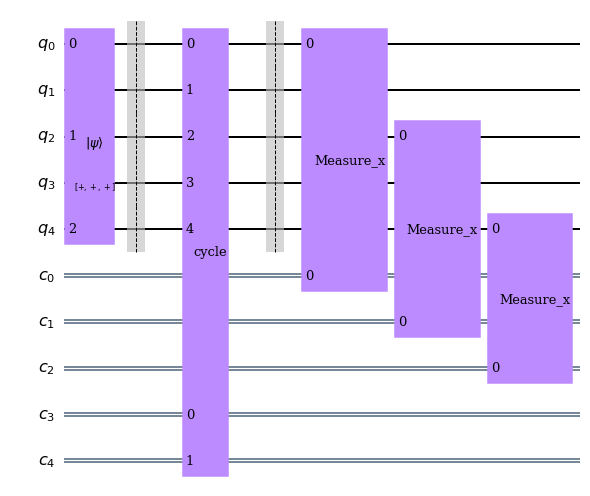

In [8]:
circ = error_correction_cycle(distance=3, repetitions=1)
circ.draw('mpl')

Let's schedule it on a 6-qubit quantum processor:

In [9]:
backend = provider.get_backend('EMU:6Q:PHYSICAL_CATS')

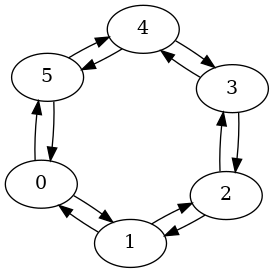

In [10]:
backend.coupling_map.draw()

/home/jdumazer/ab/emulation-examples/venv/lib/python3.9/site-packages/qiskit/utils/classtools.py:112: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  retval = method(*args, **kwargs)


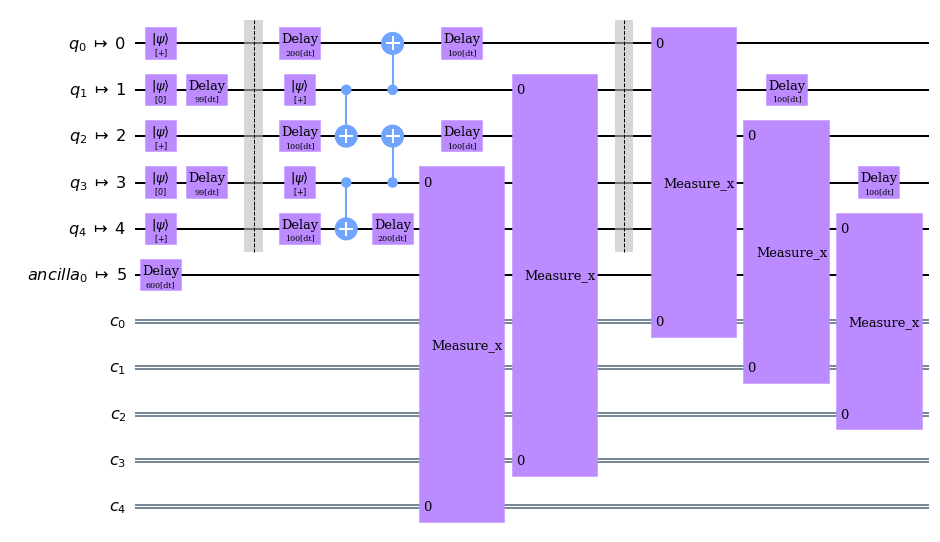

In [11]:
transpile(circ, backend).draw('mpl')

The next cell simulate the circuit and computes the logical phase flip error rate introduced by this repetition code.

The logical phase flip error rate is measured by comparing the measurement of the data qubits performed at the end of the circuit with the decoded syndrome measured by the repetition code.

In [12]:
decoder = Decoder(distance=3, repetitions=1)
raw_results = execute(circ, backend, shots=100_000).result().get_counts()
results = extract_results(distance=3, counts=raw_results)
print('Logical phase flip error rate:', decode_results(decoder, results))

Logical phase flip error rate: 0.00024


Below is a quantitative study of the impact of the repetition code distance and of quality of the quantum processor.

The quality of the quantum processor is determined by the ratio $\kappa_1/\kappa_2$ of the single-photon loss $\kappa_1$ and the two-photon loss $\kappa_2$. The lower the better the quality.

In [ ]:
k1 = 100
k2s = np.logspace(4, 7, 10)
nbar = 16
distances = [3, 5, 7, 9]
shots = int(1e5)

logical_error_rates = {}

for distance in tqdm(distances):
    repetitions = distance
    circ = error_correction_cycle(distance=distance, repetitions=repetitions)
    decoder = Decoder(distance=distance, repetitions=repetitions)
    this_rates = []
    for k2 in tqdm(k2s):
        backend = provider.get_backend(
            'EMU:40Q:PHYSICAL_CATS',
            average_nb_photons=nbar, kappa_1=k1, kappa_2=k2
        )
        raw_results = execute(circ, backend, shots=shots).result().get_counts()
        results = extract_results(distance=distance, counts=raw_results)
        this_rates.append(decode_results(decoder, results))
    logical_error_rates[distance] = np.array(this_rates)

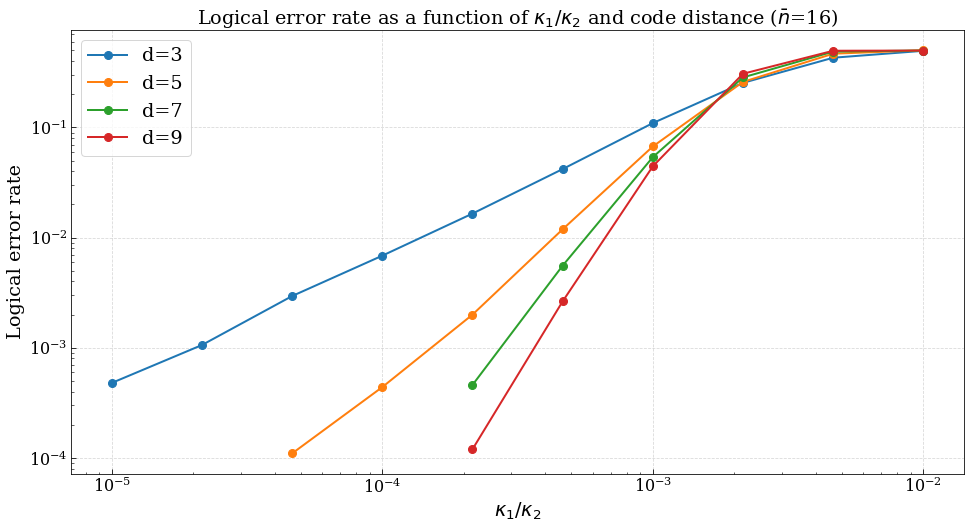

In [16]:
threshold = 10.0 / shots

plt.figure()
plt.title(f'Logical error rate as a function of $\\kappa_1/\\kappa_2$ and code distance ($\\bar n$={nbar})')
plt.xlabel('$\\kappa_1/\\kappa_2$')
plt.ylabel('Logical error rate')
for distance, error_rates in logical_error_rates.items():
    precise_enough = np.nonzero(error_rates >= threshold)[0]
    plt.plot(k1/k2s[precise_enough], error_rates[precise_enough], label=f'd={distance}', marker='o', lw=2, ms=8)
plt.legend()
plt.semilogx()
plt.semilogy()
plt.show()

Here's the corresponding plot in the paper. 

Note that the error rate is generally lower in the paper than in the results above. The reason is that the paper assumes that the final measurement of the data qubits is perfect (i.e., noiseless). This is customary in the study of error correction codes, where we assume we can "open the box" to evaluate the performance of the error correction code. In the emulation however, we cannot do that: the measurements of data qubits are noisy as well, thus increasing the logical error rate.

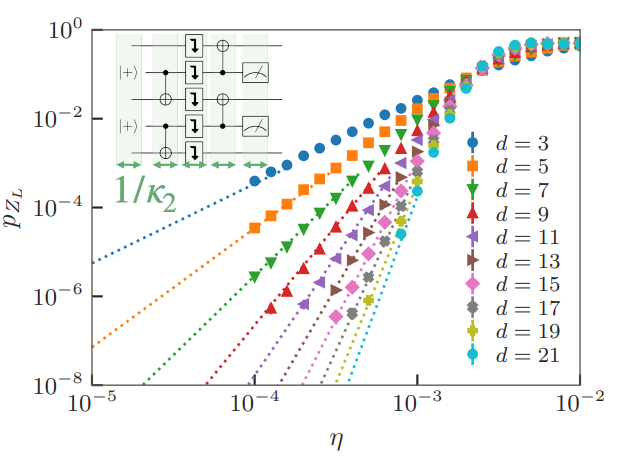